## Import Libraries

In [1]:
import sys

sys.path.append('/home/michele.prencipe/tesi/transformer/swin2sr')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from data_loader.read_mrc import read_mrc
from tests.training import *
from skimage import io, color
from utils.utils import set_global_seed
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
set_global_seed(42)

/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/localscratch/miniforge3/envs/transformer/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Set Directories

In [2]:
from data_loader.biosr_dataset import BioSRDataLoader

# Define your working directory and data directory
work_dir = "."
tensorboard_log_dir = os.path.join(work_dir, "tensorboard_logs")
os.makedirs(tensorboard_log_dir, exist_ok=True)
data_dir = '/group/jug/ashesh/data/BioSR/'


## Load Data

In [3]:
from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (768,768) #to put it into the config

dataset, train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = create_dataset(config, 
                                                datadir='/group/jug/ashesh/data/BioSR/', transform = None, 
                                                noisy_data = False)


Resizing to shape (1004, 1004). MUST BE REMOVED IN PRODUCTION!
Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


In [4]:
#from configs.biosr_config import get_config
config = get_config()

resize_to_shape = (1004,1004) #to put it into the config
transform = Augmentations()

noisy_dataset, noisy_train_dataset, noisy_val_dataset, noisy_test_dataset, noisy_train_loader, noisy_val_loader, noisy_test_loader = create_dataset(config,
                                                                                                                datadir='/group/jug/ashesh/data/BioSR/',
                                                                                                                transform = None,
                                                                                                                noisy_data = True,
                                                                                                                noisy_factor = 1000,
                                                                                                                gaus_factor = 1000)


Resizing to shape (1004, 1004). MUST BE REMOVED IN PRODUCTION!
Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


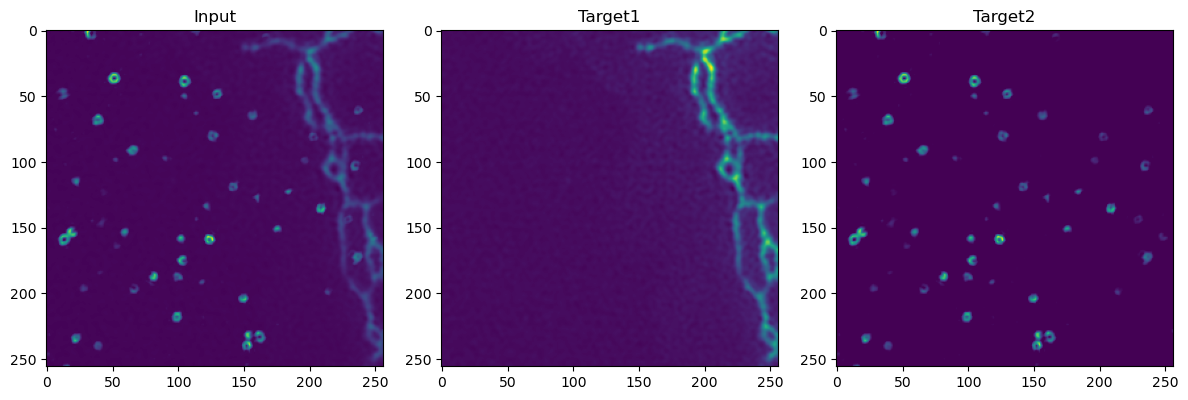

In [5]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))  # 1 riga, 2 colonne

inputs, target = noisy_train_dataset[0]


# Primo subplot
ax1.imshow(inputs)
ax1.set_title('Input')

# Secondo subplot
ax2.imshow(target[0])
ax2.set_title('Target1')

# Secondo subplot
ax3.imshow(target[1])
ax3.set_title('Target2')


# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()

In [6]:
# # Crea la figura con 1 riga e 2 colonne
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# # Primo subplot
# ax1.imshow(dataset[0][0])
# ax1.set_title('Non-noisy')

# # Secondo subplot
# ax2.imshow(noisy_dataset[0][0])
# ax2.set_title('Noisy')
# # Mostra il grafico
# plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
# plt.show() 


## Create Model

### Swin2SR

In [7]:
# depths = [6, 6, 6, 6]
# num_heads = [6, 6, 6, 6]
depths = [3, 3]
num_heads = [3, 3]

from tests.training import Swin2SRModule
from configs.biosr_config import get_config

config = get_config()

# Initialize the model
model = Swin2SRModule(config)



model.load_state_dict(torch.load('/home/michele.prencipe/tesi/transformer/swin2sr/logdir/q191yl47swin2sr'))

<All keys matched successfully>

## Inference

In [8]:
from torch import nn as nn
# Validation loop (optional but recommended)
model.eval()  # Set model to evaluation mode
model = model.cuda()
criterion = nn.MSELoss()
val_loss = 0.0
test_inputs = []
test_outputs = []
test_targets = []
test_inputs_denormalized =[]
test_outputs_denormalized=[]
test_targets_denormalized = []

c1_min, c1_max, c2_min, c2_max = noisy_dataset.get_normalization_params() #of the entire dataset
print(c1_max, c2_max, c1_min, c2_min)

with torch.no_grad():
    for inputs, targets in noisy_test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()                

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute loss
        
        val_loss += loss.item()  # Accumulate loss
        
        
        targets[:,0,:,:] = targets[:,0,:,:]*(c1_max - c1_min) + c1_min
        targets[:,1,:,:] = targets[:,1,:,:]*(c2_max - c2_min) + c2_min
        outputs[:,0,:,:]  = outputs[:,0,:,:]*(c1_max - c1_min) + c1_min
        outputs[:,1,:,:]  = outputs[:,1,:,:]*(c2_max - c2_min) + c2_min
        
        
        test_inputs.append(inputs.cpu().numpy())
        test_outputs.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())        

        # Ensure outputs and targets have the same dimensions for loss computation
        if outputs.shape != targets.shape:
            print(f"Output shape: {outputs.shape}, Target shape: {targets.shape}")
            raise ValueError("Output and target shapes do not match!")       

test_inputs = np.concatenate(test_inputs, axis=0)
test_outputs = np.concatenate(test_outputs, axis=0)
test_targets = np.concatenate(test_targets, axis=0)



# Compute average validation loss for the epoch
val_loss = val_loss / len(noisy_test_loader)
print(f'Validation Loss: {val_loss:.9f}')


65535 65535 0 0
Validation Loss: 0.002064636


## Metric Calculation

In [9]:
from collections import defaultdict
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from utils.util_calculate_psnr_ssim import calculate_psnr, calculate_ssim
from core.psnr import PSNR

psnr_arr = {0: [], 1: []}
ssim_arr = defaultdict(list)


for ch_idx in range(test_outputs.shape[1]):
    if ch_idx == 0:
        data_range = c1_max - c1_min
    else: 
        data_range = c2_max - c2_min
    psnr_arr[ch_idx].append(PSNR(test_targets[:, ch_idx, :, :], test_outputs[:, ch_idx, : , : ], range_= data_range))
    

In [10]:
print(psnr_arr)

{0: [tensor([28.2183, 23.0573, 26.0179, 24.9389, 22.1143, 25.0109])], 1: [tensor([31.9680, 31.0885, 31.5845, 34.6580, 37.2682, 31.7029])]}


In [11]:
print("psnr channel 1:", np.mean(psnr_arr[0]))
print("psnr channel 2:", np.mean(psnr_arr[1]))

psnr channel 1: 24.89293
psnr channel 2: 33.045


## Visual Evaluation

Index: 3


Text(0.5, 1.0, 'Target')

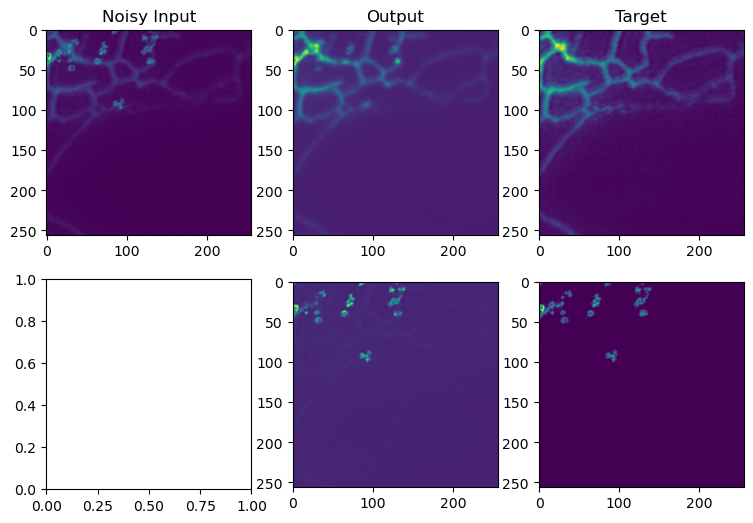

In [12]:
idx = 3
print(f"Index: {idx}")
img_sz = 3
ncols = 3
nrows = 2
_, ax = plt.subplots(figsize=(img_sz*ncols, img_sz*nrows), ncols=ncols,nrows=nrows)
ax[0,0].imshow(test_inputs[idx,0])
ax[0,1].imshow(test_outputs[idx,0])
ax[0,2].imshow(test_targets[idx,0])
ax[1,1].imshow(test_outputs[idx,1])
ax[1,2].imshow(test_targets[idx,1])

ax[0,0].set_title('Noisy Input')
ax[0,1].set_title('Output')
ax[0,2].set_title('Target')

In [13]:
with torch.no_grad():
    for inputs, targets in noisy_test_loader:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Ensure inputs and targets have the correct dimensions
        if len(inputs.shape) == 3:  # If inputs are [batch_size, height, width]
            inputs = inputs.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
        if len(targets.shape) == 3:  # If targets are [batch_size, height, width]
            targets = targets.unsqueeze(1)  # Add channel dimension to make it [batch_size, 1, height, width]
       
        outputs = model(inputs) # Forward pass        
        
        outputs = outputs.cpu().numpy()
        targets = targets.cpu().numpy()
        
        targets[:,0,:,:] = targets[:,0,:,:]*(c1_max - c1_min) + c1_min
        targets[:,1,:,:] = targets[:,1,:,:]*(c2_max - c2_min) + c2_min
        outputs[:,0, :,:]  = outputs[:,0,:,:]*(c1_max - c1_min) + c1_min
        outputs[:,1, :,:]  = outputs[:,1,:,:]*(c2_max - c2_min) + c2_min
        
        break


In [14]:
print(np.min(outputs[0,0]))
print(np.max(outputs[0,0]))
print(np.min(targets[0,0]))
print(np.max(targets[0,0]))

-4889.2544
40757.156
748.0
10203.0


## Stitching Predictions


In [15]:
from predtiler.dataset import get_tiling_dataset, get_tile_manager

patch_size = 256
tile_size = 128
data_shape = dataset.c2_data.shape[::-1] # size of the data you are working with
manager = get_tile_manager(data_shape=data_shape, tile_shape=(1,tile_size,tile_size), 
                               patch_shape=(1,patch_size,patch_size))

    
dset_class = get_tiling_dataset(BioSRDataLoader, manager)
dataset = dset_class(root_dir='/group/jug/ashesh/data/BioSR/', 
                                resize_to_shape=None,
                                transform=None,
                                noisy_data=True,
                                noise_factor=1000, 
                                gaus_factor=2000, patch_size = patch_size
                                )

test_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

Norm Param:  0 0 65535 65535
c1_data shape: (1004, 1004, 68)
c2_data shape: (1004, 1004, 54)


In [16]:
from predtiler.tile_stitcher import stitch_predictions

predictions = []
for inp, targ in test_loader:
    
    inp, _ = inp.cuda(), targ.cuda()
    if len(inp.shape) == 3:  
        inp = inp.unsqueeze(1)        
    #TODO Chiedere se devo denormalizzare qui
    pred = model(inp)
    predictions.append(pred.cpu().detach().numpy())

predictions = np.concatenate(predictions, axis = 0) # shape: (number_of_patches, C, patch_size, patch_size)


stitched_pred = stitch_predictions(predictions, dataset.tile_manager)



[54, 1004, 1004, 2]


In [18]:
print(manager)
print(predictions.shape)
print(stitched_pred.shape)

TileIndexManager(data_shape=(54, 1004, 1004), grid_shape=(1, 128, 128), patch_shape=(1, 256, 256), tiling_mode=2)
(2646, 2, 256, 256)
(54, 1004, 1004, 2)


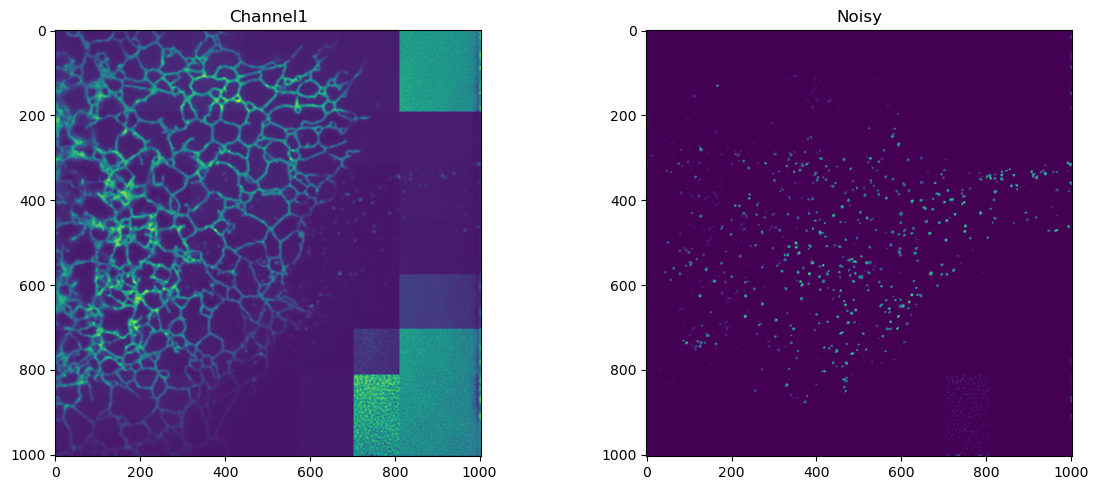

In [22]:
# Crea la figura con 1 riga e 2 colonne
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne

# Primo subplot
ax1.imshow(stitched_pred[0,:, :, 0])
ax1.set_title('Channel1')

# Secondo subplot
ax2.imshow(stitched_pred[0,:, :, 1], vmin = test_targets[idx, 1].min())
ax2.set_title('Noisy')
# Mostra il grafico
plt.tight_layout()  # Adatta il layout per evitare sovrapposizioni
plt.show()
